## Use case - Predictive Maintenance for Toy train
In this assignment you will work with a dataset (toy-train.arff) collected from a toy train riding along a track. It was collected using a Raspberry Pi, a Sense HAT (an add-on board with sensors) and a battery powered toy train.


The train rides on the track seen in the pictures below, and it pulls the Raspberry Pi, mounted on top of a power bank, in one of the wagons. On the track there's a small bridge (located close to the yellow duck) that introduces a small uphill and downhill.

Data is collected during **eight laps** where the following sensor values are collected **twice per second**.
- temperature - The temperature on board the Raspberry Pi
- pressure - The atmospheric pressure
- humidity - Humidity as measured by the sense hat
- gyro pitch - The pitch (up / down) angle of the Pi. Zero degrees indicates a horizontal Pi.
- gyro roll - The roll in degrees where zero indicates a horizontal Pi.
- gyro yaw - The yaw in degrees from 0 to 360, similar to a compass reading.

At first glance this might seem like a very trivial example, but in fact it has many properties that are present in most real world scenarios. First, each lap can be seen as one process cycle with varying operational settings. Secondly, the process cycle is quite stable delivering similar values each round. Thirdly, the sensors are not always well calibrated.

## Objectives
The objective of this assignment is to create a simple predictive maintenance solution that monitors the train's health. You can assume that **at least the two first laps are recorded when at good health**. General design of your solution should be to predict the gyro yaw at horizon t+10 i.e. ten steps into the future and compare the predictions to reality. You are free to use any ML-library and programming language that you like, but you are not allowed to use a workbench e.g. Knime since programming will be a daily activity for you. Don’t use Long short-term memory (LSTM) neural networks to solve the problem since these usually do not meet the requirements of the constrained platforms Ekkono is usually applied to.


You should hand in the following:
- The script containing the code you used to train and evaluate your models.
- Your best estimation (using an appropriate error metric) of the predictive performance of your model when applied to new data.
- The best ML model you can create for the problem.
- A chart showing the health of the train for each instance in the dataset.

You are free to make your own assumption on anything not specified in the assignment as long as you can give a reasonable motivation.


The information about how sense HAT is working and collect data can be found <a href="https://pythonhosted.org/sense-hat/api/#imu-sensor">here</a>.


- gyro pitch shows
    - rotation around y-axis
        - The bridge make a significant change in gyro pitch. Its effect should be noticeable in the dataset.
- gyro roll shows
    - rotation around x-axis
- gyro yaw shows
    - rotation around z-axis
        - The gyro yaw shows the curvature of the path. Change in its value shows where the track turns and how much.


<span style="color:blue"> The yaw rate sensor is a key component in a vehicle’s stability control or electronic stability control system. Yaw can be defined as the movement of an object turning on its vertical axis. The yaw rate sensor determines how far off-axis a car is “tilting” in a turn using gyroscopes to monitor the slip angle, the angle between the vehicle’s heading and actual movement direction. This information is then fed into the vehicle’s computer to evaluate the wheel speed, steering angle and accelerator position, and, if the system senses too much yaw, the appropriate braking force is automatically applied.
By comparing the vehicle’s actual yaw rate to the target yaw rate, the on-board computer can identify to what degree the vehicle may be under- or over-steering, and what corrective action, if any, is required. Corrective action may include reducing engine power as well as applying the brake on one or more wheels to realign the vehicle. </span>

Based on the above paragraph, yaw rate is necessary (but not enough) to determine torque which is subjected to the vehicle in a curved path.


Quick summary:
- <span style="color:red">Information:</span>

    - The status of the train is healthy during the first two laps,
    - No precise label for the remaining laps,
    - The time period of each lap is not equal.

- <span style="color:red">Task:</span>

    - Predict gyro yaw in 10 steps ahead.
    - Label the status of train in each instance of dataset as "Healthy" and "Unhealthy".

- <span style="color:red">Assumption:</span>

    - The data from the first two lap is reliable to label healthy.
    - There is a difference between the values of gyro yaw in first two laps which means that there is a reasonable error under which the train is still in a healthy mode.

- <span style="color:red">Suggestion:</span>

    - Collaborating with an engineer to better understand the relation between gyro yaw and the operation of the vehicle.


## Data fetch

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.io import arff

In [2]:
data = arff.loadarff("toy-train.arff")
dataFrame = pd.DataFrame(data[0])
dataFrame

,temperature,pressure,humidity,gyro_pitch,gyro_roll,gyro_yaw
0,39.59,1017.30,22.54,2.83,1.26,210.09
1,39.81,1017.31,22.57,2.83,1.26,210.08
2,39.61,1017.31,22.93,2.83,1.26,210.12
3,39.74,1017.31,22.16,2.83,1.26,210.22
4,39.68,1017.32,22.69,2.84,1.26,210.27
...,...,...,...,...,...,...
2330,40.71,1017.39,20.88,2.70,2.18,195.77
2331,40.67,1017.38,22.21,2.58,2.47,209.98
2332,40.64,1017.38,21.67,2.75,2.55,222.33
2333,40.77,1017.38,20.64,2.72,2.42,233.20


In [3]:
dataFrame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2335 entries, 0 to 2334
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   temperature  2335 non-null   float64
 1   pressure     2335 non-null   float64
 2   humidity     2335 non-null   float64
 3   gyro_pitch   2335 non-null   float64
 4   gyro_roll    2335 non-null   float64
 5   gyro_yaw     2335 non-null   float64
dtypes: float64(6)
memory usage: 109.6 KB


<span style="color:blue">
Dataset contains numeric values and does not contain missing values.
</span>

## Data visualization

### Analysing features independently

In [4]:
font = {'family': 'serif', 'color': 'blue', 'size': 20}

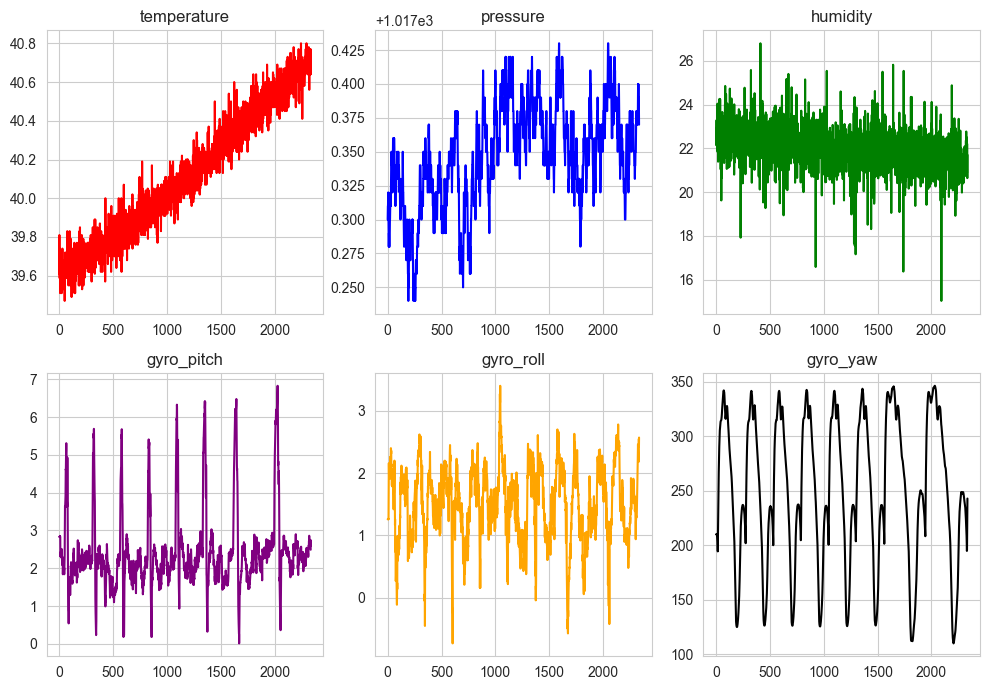

In [5]:
column = list(dataFrame.columns)
fig, axs = plt.subplots(2, 3, figsize=(10, 7))
colors = ["red", "blue", "green", "purple", "orange", "black"]

# loop through the columns and plot the box plots
for i, (ax, column) in enumerate(zip(axs.flatten(), column)):
    ax.plot(dataFrame.index, dataFrame[column], color=colors[i])
    ax.set_title(column)

plt.tight_layout()

plt.show()

<span style="color:blue">
Eight peaks in the gyro_pitch and gyro_yaw refers to eight laps. Let's look at them more closely and try to split the first two laps.
</span>

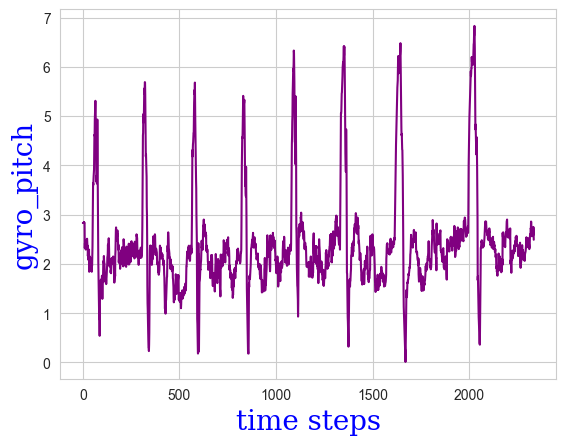

In [6]:
plt.plot(dataFrame['gyro_pitch'], color="purple")
plt.xlabel('time steps', fontdict=font)
plt.ylabel('gyro_pitch', fontdict=font)
plt.show()

<span style="color:blue">
The above figure shows the behaviour of gyro pitch in terms of time steps. Due to the bridge, one can see a sharp change (highest to lowes) in a short period of time in gyro pitch.
</span>

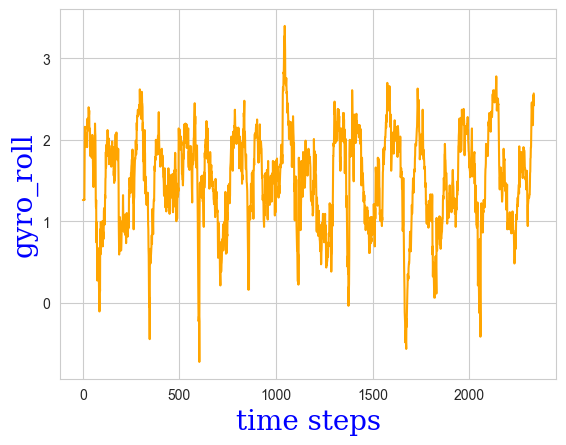

In [7]:
plt.plot(dataFrame['gyro_roll'], color='orange')
plt.xlabel('time steps', fontdict=font)
plt.ylabel('gyro_roll', fontdict=font)
plt.show()

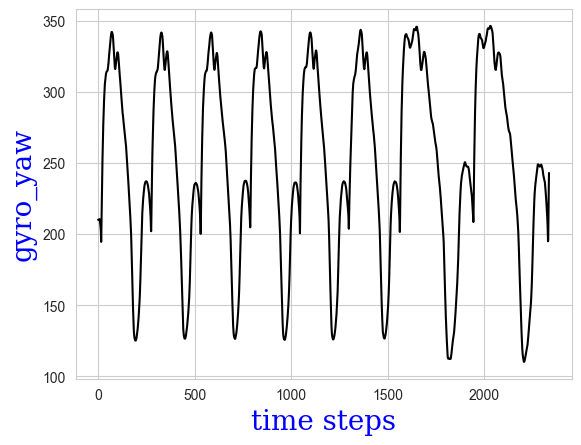

In [8]:
plt.plot(dataFrame['gyro_yaw'], color='black')
plt.xlabel('time steps', fontdict=font)
plt.ylabel('gyro_yaw', fontdict=font)
plt.show()

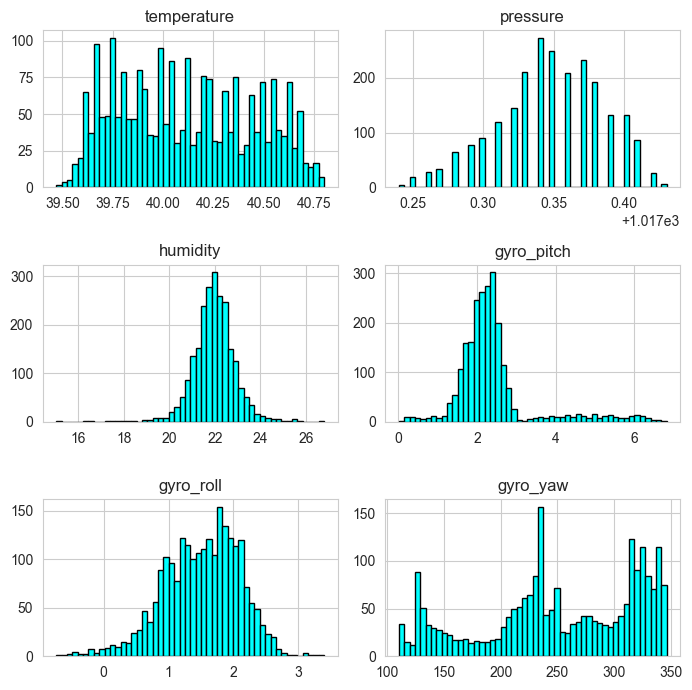

In [9]:
dataFrame.hist(bins=50, figsize=(7, 7), color='cyan', edgecolor='black')
plt.tight_layout()
plt.show()

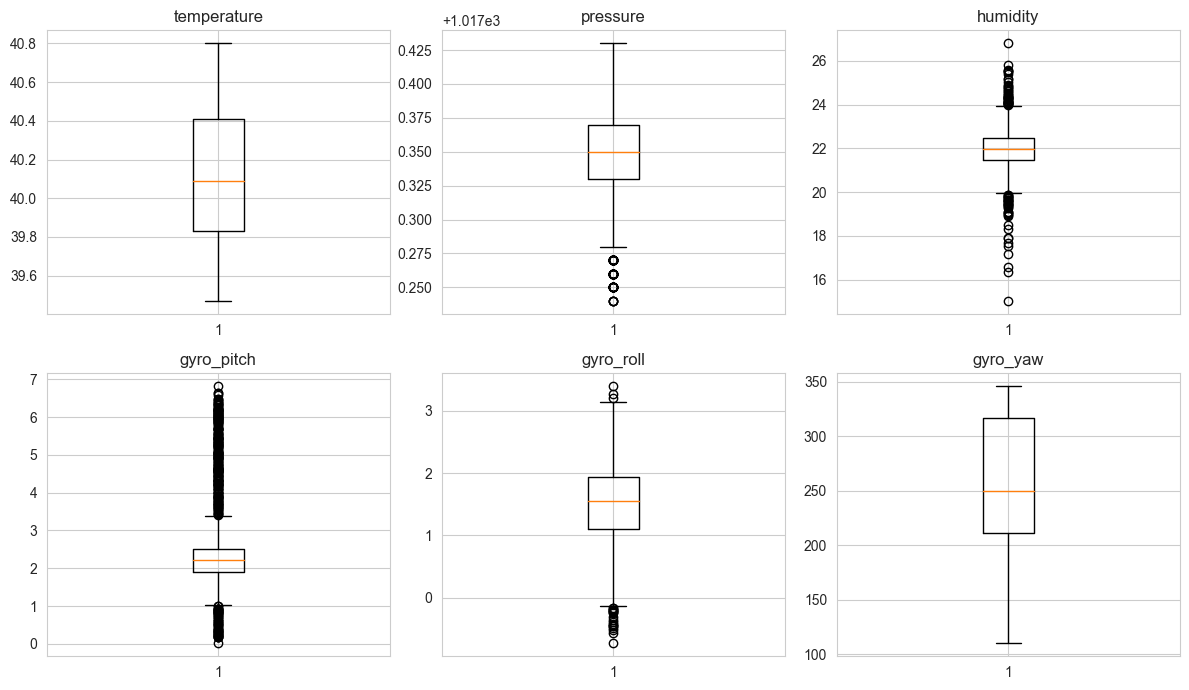

In [10]:
# box plots
column = list(dataFrame.columns)
fig, axs = plt.subplots(2, 3, figsize=(12, 7))

for ax, column in zip(axs.flatten(), column):
    ax.boxplot(dataFrame[column])
    ax.set_title(column)

plt.tight_layout()
plt.show()

### Analysing feature correlation

In the box below, I look at the scatter plot between different columns and gyro_yaw. It shows that gyro_yaw do not have a linear relationship with other features.

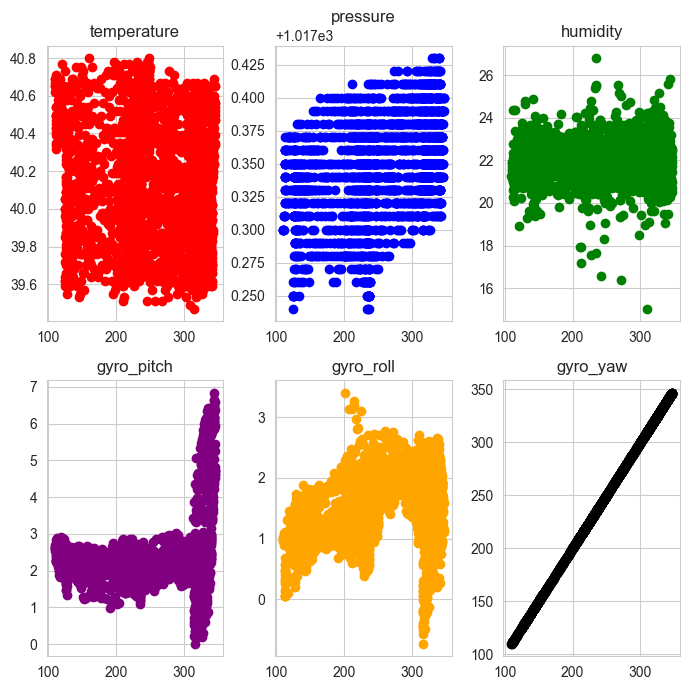

In [11]:
column = list(dataFrame.columns)

fig, axs = plt.subplots(2, 3, figsize=(7, 7))
colors = ["red", "blue", "green", "purple", "orange", "black"]

for i, (ax, column) in enumerate(zip(axs.flatten(), column)):
    ax.scatter(dataFrame['gyro_yaw'], dataFrame[column], color=colors[i])
    ax.set_title(column)

plt.tight_layout()
plt.show()

In the box below, I look at the scatter plot between different columns and gyro_yaw. It shows that gyro_yaw do not have a linear relationship with other features. What I understand from heatmap is that in contrast to other features, temperature has a negative relation with gyro_yaw. The most effective features on gyro_yaw is pressure, temperature, etc. . However, the assignment is a time series and one serious question comes up: Does this correlation give away any useful information?

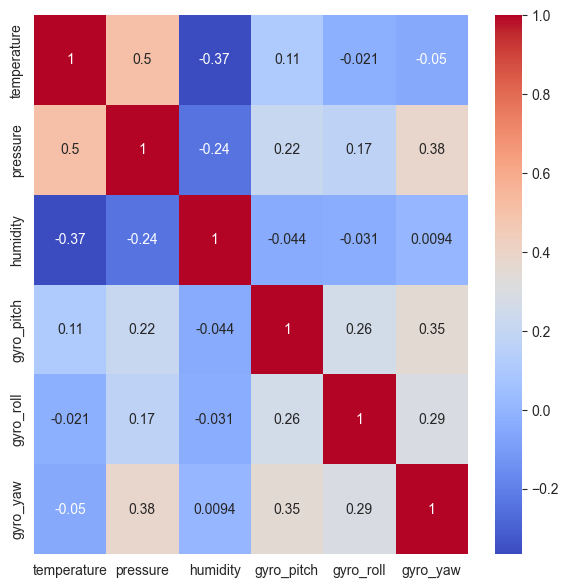

In [12]:
plt.figure(figsize=(7, 7))
sns.heatmap(dataFrame.corr(), annot=True, cmap='coolwarm')
plt.show()

## Contextual analyses
### Length of first two laps in seconds
Since only the first two laps are known to be healthy, extracting the data related to rounds one and two are needed. Later we can **only** use the data from these two laps to train and test our model. The data from other laps can be considered "unseen data".

### Acceptable value/error range for gyro yaw
Since the data measured in first two laps is known to be valid, and the train has stayed on rail during those two laps, we can deduce an approximation of the reasonable range of value/error for gyro yaw using the data of those two laps.

 You can find out the process though which we measured those parameters [here](FirstTwoLaps.ipynb)

## Solution

### Only using gyro yaw to predict gyro yaw.
[Random Forest Univariate](UnivariateRF.ipynb)

### Using all the features to predict gyro yaw.
[Random Forest Multivariate](MultivariateRF.ipynb)


## Other results
### uni-variant
#### RF
##### R-Square
##### Mean Absolute Error
